In [15]:
%reset -f
%config InteractiveShell.ast_node_interactivity = 'all'

# Fetching all Air Quality datasets into their dataframes
# Perform immediate concatenation per year
import os
import pandas as pd

# Initialize (do not add extra datasets to dir)
dir = 'CAdata/'
colidx = [0,2,4,17]     # column indexes to use
innerkeys = ['Date', 'Site ID', 'COUNTY']
dataA2020 = pd.read_csv(dir + 'cf-2020-co.csv', parse_dates=True, usecols=colidx)
dataA2021 = pd.read_csv(dir + 'cf-2021-co.csv', parse_dates=True, usecols=colidx)
dataA2022 = pd.read_csv(dir + 'cf-2022-co.csv', parse_dates=True, usecols=colidx)

with os.scandir(dir) as datasets:
    for dataset in datasets:
        if dataset.is_file() and 'co' not in dataset.name:
            temp = pd.read_csv(dataset, parse_dates=True, usecols=colidx)
            if '2020' in dataset.name:
                # cols_to_use = dataA2020.columns.difference(temp)
                dataA2020 = pd.merge(dataA2020, temp, how='outer', on=innerkeys)
            elif '2021' in dataset.name:
                # cols_to_use = dataA2021.columns.difference(temp)
                dataA2021 = pd.merge(dataA2021, temp, how='outer', on=innerkeys)
            elif '2022' in dataset.name:
                # cols_to_use = dataA2022.columns.difference(temp)
                dataA2022 = pd.merge(dataA2022, temp, how='outer', on=innerkeys)

# Parse Dates to date
dataA2020['Date'] = pd.to_datetime(dataA2020['Date'])
dataA2021['Date'] = pd.to_datetime(dataA2021['Date'])
dataA2022['Date'] = pd.to_datetime(dataA2022['Date'])

dataA2020 = dataA2020.groupby(by=['Date', 'Site ID']).mean().groupby(by=['Date']).mean()
dataA2021 = dataA2021.groupby(by=['Date', 'Site ID']).mean().groupby(by=['Date']).mean()
dataA2022 = dataA2022.groupby(by=['Date', 'Site ID']).mean().groupby(by=['Date']).mean()

dataA = pd.concat([dataA2020, dataA2021, dataA2022])

new_names = ['CO conc (ppm)', 'NO2 conc (ppb)', 'O3 conc (ppm)',
             'Pb conc (ug/m3 SC)', 'PM10 conc (ug/m3 SC)',
             'PM2.5 conc (ug/m3 LC)', 'SO2 conc (ppb)']

dataA2020.head()
dataA2021.head()
dataA2022.head()
dataA.head()

# Rename columns
for i in range(len(new_names)):
    dataA.rename(columns={dataA.columns[i]: new_names[i]}, inplace=True)

dataA.head()

import seaborn as sns

# Deciding whether to drop or impute null values, so we check how many null values there are.
# Dataset A impute
print("A: Number of entries with null values:", dataA.isna().any(axis=1).sum())
print("A: Number of entries:", dataA.shape[0])

# These imports are important, imputer relies on them.

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer   # Important!
from sklearn.impute import IterativeImputer     # default imputer is BayesianRidge

from sklearn.linear_model import BayesianRidge

# Initialize imputer
imp = IterativeImputer(max_iter=100, random_state=1, verbose=True)
dataA[:] = imp.fit_transform(dataA)

dataA.head()

C:\Users\NItro\AppData\Local\Temp\ipykernel_2644\2817092688.py:36: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\NItro\AppData\Local\Temp\ipykernel_2644\2817092688.py:37: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\NItro\AppData\Local\Temp\ipykernel_2644\2817092688.py:38: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Daily Max 8-hour CO Concentration,Daily Max 1-hour NO2 Concentration,Daily Max 8-hour Ozone Concentration,Daily Mean Pb Concentration,Daily Mean PM10 Concentration,Daily Mean PM2.5 Concentration,Daily Max 1-hour SO2 Concentration
Date,,,,,,,
2020-01-01,0.606780,19.129570,0.030783,0.008000,17.211765,13.533446,1.236
2020-01-02,0.643220,24.476087,0.028740,0.013000,16.750000,11.087611,1.228
2020-01-03,0.794915,28.616304,0.027643,0.018990,19.861446,13.664307,1.236
2020-01-04,0.817797,24.173913,0.031677,0.011233,19.096774,11.571699,1.140
2020-01-05,0.714407,20.461828,0.033058,0.009000,13.103659,9.578448,0.884


,Daily Max 8-hour CO Concentration,Daily Max 1-hour NO2 Concentration,Daily Max 8-hour Ozone Concentration,Daily Mean Pb Concentration,Daily Mean PM10 Concentration,Daily Mean PM2.5 Concentration,Daily Max 1-hour SO2 Concentration
Date,,,,,,,
2021-01-01,0.642982,20.597872,0.030336,0.021500,15.517045,13.344805,1.100000
2021-01-02,0.625439,20.771053,0.028085,0.010000,17.964706,12.023790,0.792593
2021-01-03,0.613158,20.455319,0.028695,0.008000,18.927711,13.015200,0.842308
2021-01-04,0.613158,22.205789,0.031188,0.007455,18.474926,9.849903,0.866667
2021-01-05,0.628947,25.500532,0.027467,0.027000,17.523810,10.025600,0.980000


,Daily Max 8-hour CO Concentration,Daily Max 1-hour NO2 Concentration,Daily Max 8-hour Ozone Concentration,Daily Mean Pb Concentration,Daily Mean PM10 Concentration,Daily Mean PM2.5 Concentration,Daily Max 1-hour SO2 Concentration
Date,,,,,,,
2022-01-01,0.541837,19.519231,0.033708,NaN,13.477528,10.529359,0.600000
2022-01-02,0.602041,23.307065,0.031556,NaN,12.318681,9.344264,1.005000
2022-01-03,0.680612,25.995055,0.031120,NaN,15.823864,8.316667,0.860000
2022-01-04,0.652041,26.605618,0.029597,NaN,17.174419,8.361370,0.842105
2022-01-05,0.687755,26.740217,0.028671,0.008412,17.867868,8.859782,0.761905


,Daily Max 8-hour CO Concentration,Daily Max 1-hour NO2 Concentration,Daily Max 8-hour Ozone Concentration,Daily Mean Pb Concentration,Daily Mean PM10 Concentration,Daily Mean PM2.5 Concentration,Daily Max 1-hour SO2 Concentration
Date,,,,,,,
2020-01-01,0.606780,19.129570,0.030783,0.008000,17.211765,13.533446,1.236
2020-01-02,0.643220,24.476087,0.028740,0.013000,16.750000,11.087611,1.228
2020-01-03,0.794915,28.616304,0.027643,0.018990,19.861446,13.664307,1.236
2020-01-04,0.817797,24.173913,0.031677,0.011233,19.096774,11.571699,1.140
2020-01-05,0.714407,20.461828,0.033058,0.009000,13.103659,9.578448,0.884


,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),Pb conc (ug/m3 SC),PM10 conc (ug/m3 SC),PM2.5 conc (ug/m3 LC),SO2 conc (ppb)
Date,,,,,,,
2020-01-01,0.606780,19.129570,0.030783,0.008000,17.211765,13.533446,1.236
2020-01-02,0.643220,24.476087,0.028740,0.013000,16.750000,11.087611,1.228
2020-01-03,0.794915,28.616304,0.027643,0.018990,19.861446,13.664307,1.236
2020-01-04,0.817797,24.173913,0.031677,0.011233,19.096774,11.571699,1.140
2020-01-05,0.714407,20.461828,0.033058,0.009000,13.103659,9.578448,0.884


A: Number of entries with null values: 359
A: Number of entries: 1096
[IterativeImputer] Completing matrix with shape (1096, 7)
[IterativeImputer] Change: 0.013314017907579814, scaled tolerance: 0.2222875 
[IterativeImputer] Early stopping criterion reached.


,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),Pb conc (ug/m3 SC),PM10 conc (ug/m3 SC),PM2.5 conc (ug/m3 LC),SO2 conc (ppb)
Date,,,,,,,
2020-01-01,0.606780,19.129570,0.030783,0.008000,17.211765,13.533446,1.236
2020-01-02,0.643220,24.476087,0.028740,0.013000,16.750000,11.087611,1.228
2020-01-03,0.794915,28.616304,0.027643,0.018990,19.861446,13.664307,1.236
2020-01-04,0.817797,24.173913,0.031677,0.011233,19.096774,11.571699,1.140
2020-01-05,0.714407,20.461828,0.033058,0.009000,13.103659,9.578448,0.884


In [16]:
colidx = [0,1,2,5,6]     # column indexes to use
dataB = pd.read_csv('datasets/us_covid_cases_and_deaths_by_state.csv', parse_dates=True, usecols=colidx)
sum_new_cases = dataB['new_case'] + dataB['pnew_case']
dataB.drop(['new_case', 'pnew_case'], axis=1, inplace=True)
dataB['sum_new_cases'] = sum_new_cases
dataB.head()

dataB.columns = ['Date', 'State', 'Total Cases', 'Sum New Cases']

# Filter dataset B
dataB = dataB[dataB['State'] == 'CA']
dataB.head()

# Use Date as index, also drop the State
dataB['Date'] = pd.to_datetime(dataB['Date'])
dataB.set_index('Date', inplace=True)
dataB.sort_index(inplace=True)
dataB.drop('State', axis=1, inplace=True)
dataB.info()
dataB.head()

# Filter dataA with temporal restriction given by dataB
dataA = dataA[(dataA.index >= dataB.index.min()) &
              (dataA.index <= dataB.index.max())]

print("Filtered Dataset A")
dataA.head()

# With the printouts below, we find that there's no need to impute.
print("B: Number of entries with null values:", dataB.isna().any(axis=1).sum())
print("B: Number of entries:", dataB.shape[0])

,submission_date,state,tot_cases,sum_new_cases
0,03/11/2021,KS,297229,0.0
1,12/01/2021,ND,163565,809.0
2,01/02/2022,AS,11,0.0
3,11/22/2021,AL,841461,1060.0
4,05/30/2022,AK,251425,0.0


,Date,State,Total Cases,Sum New Cases
15543,06/11/2020,CA,139281,3090.0
15553,08/18/2020,CA,632667,4636.0
15562,02/25/2021,CA,3460326,4965.0
15573,02/10/2021,CA,3362981,8390.0
15576,09/06/2020,CA,732144,4905.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1001 entries, 2020-01-22 to 2022-10-18
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Total Cases    1001 non-null   int64  
 1   Sum New Cases  1001 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 23.5 KB


,Total Cases,Sum New Cases
Date,,
2020-01-22,0,0.0
2020-01-23,0,0.0
2020-01-24,0,0.0
2020-01-25,0,0.0
2020-01-26,0,0.0


Filtered Dataset A


,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),Pb conc (ug/m3 SC),PM10 conc (ug/m3 SC),PM2.5 conc (ug/m3 LC),SO2 conc (ppb)
Date,,,,,,,
2020-01-22,0.525000,24.782447,0.031561,0.008904,13.844353,7.054452,0.743478
2020-01-23,0.670690,26.067553,0.025876,0.010460,15.817647,8.524138,1.087500
2020-01-24,0.690351,25.952660,0.026554,0.015000,17.476190,9.846121,1.052174
2020-01-25,0.585965,21.463402,0.028829,0.009500,18.971591,12.164924,1.433333
2020-01-26,0.508772,17.300521,0.033949,0.007000,16.000000,10.825797,0.954167


B: Number of entries with null values: 0
B: Number of entries: 1001


In [17]:
# Merging the two datasets (dataA & dataB)
data = pd.concat([dataA, dataB], axis=1)
data.drop(data.columns[[3,4,5,6,7]], axis=1, inplace=True)
#data = data[data['Sum New Cases'] <= 100000]
data

,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),Sum New Cases
Date,,,,
2020-01-22,0.525000,24.782447,0.031561,0.0
2020-01-23,0.670690,26.067553,0.025876,0.0
2020-01-24,0.690351,25.952660,0.026554,0.0
2020-01-25,0.585965,21.463402,0.028829,0.0
2020-01-26,0.508772,17.300521,0.033949,0.0
...,...,...,...,...
2022-10-14,0.348958,16.988068,0.046513,7142.0
2022-10-15,0.320833,12.774719,0.043252,0.0
2022-10-16,0.321875,14.714773,0.039692,0.0


<Axes: xlabel='CO conc (ppm)', ylabel='Sum New Cases'>

<Axes: xlabel='NO2 conc (ppb)', ylabel='Sum New Cases'>

<Axes: xlabel='O3 conc (ppm)', ylabel='Sum New Cases'>

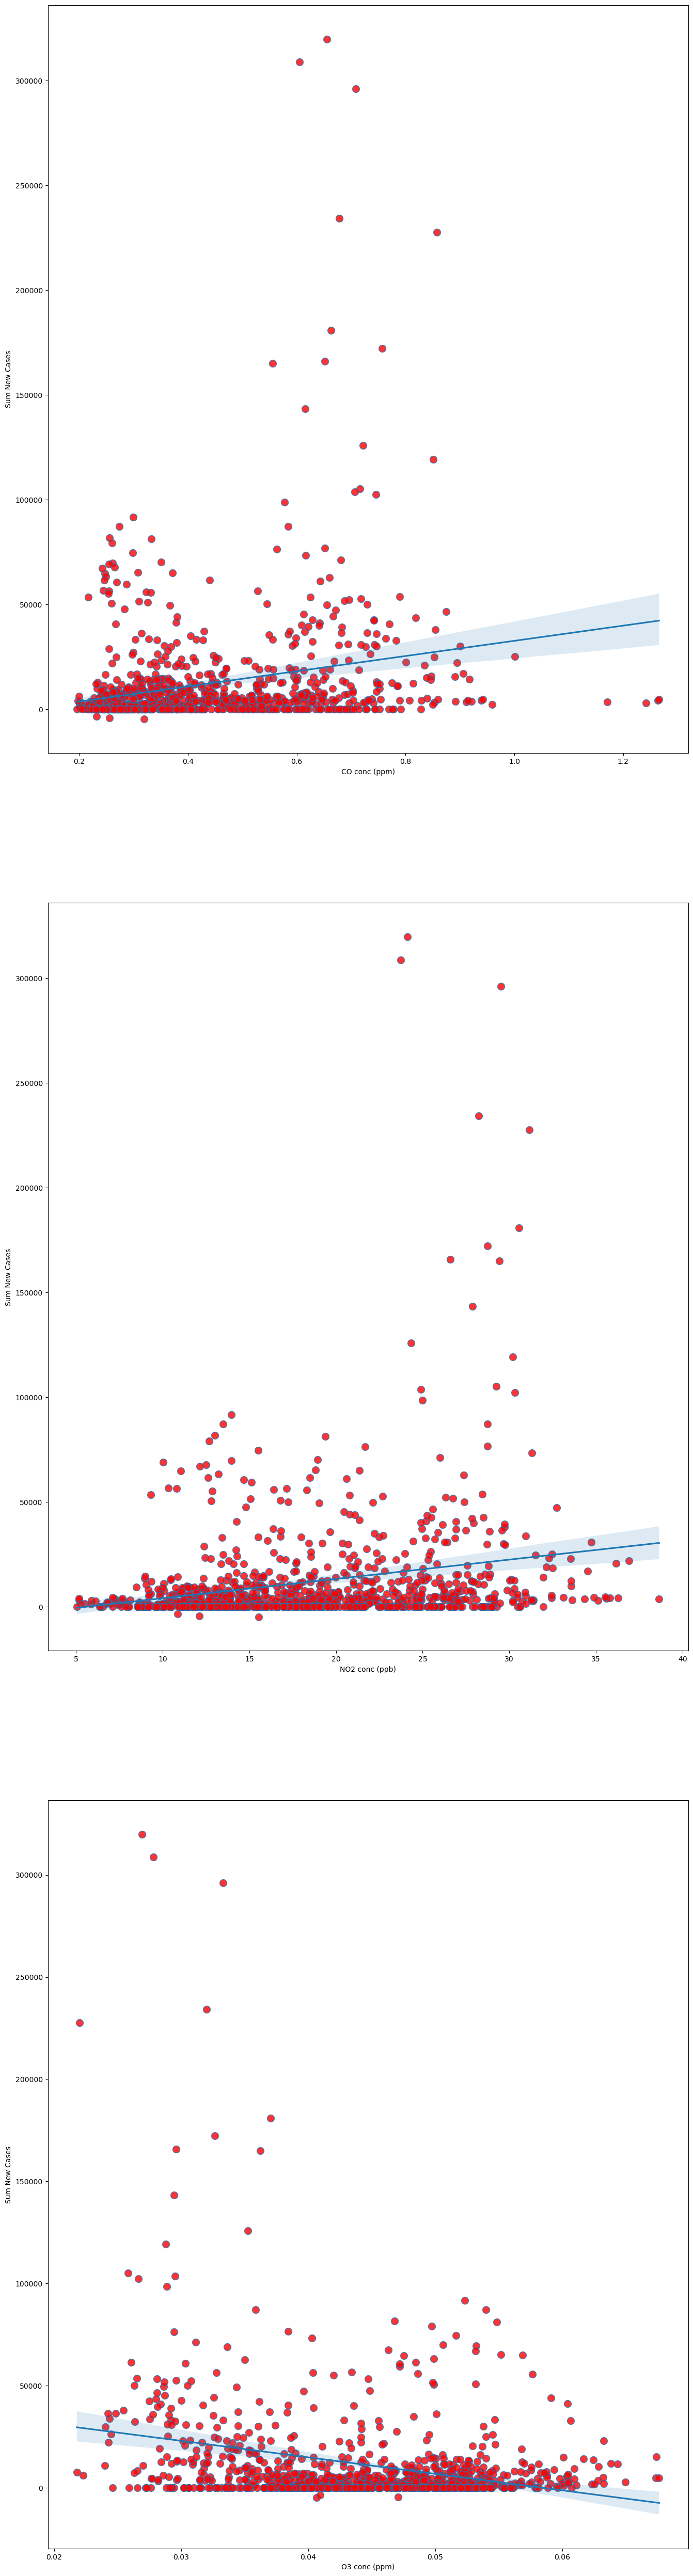

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=len(data.columns)-1, ncols=1, figsize=(16,64))

i = 0
for label in data.columns:
    if label == "Sum New Cases": continue
    sns.regplot(x=label, y='Sum New Cases', data=data, ci=95, scatter_kws={'s':100, 'facecolor':'red'}, ax=axs[i])
    i += 1

In [19]:
# Linear Regression
# PREPARE FEATURES AND TARGET DATA
X = data.iloc[:,0:-1] # feature matrix
y = data.iloc[:,-1] # target vector

# PREPARE TRAIN AND TEST DATA
# NOTE: random_state = 1
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

print("Coefficients:", regressor.coef_)
print("Intercept:", regressor.intercept_)

LinearRegression()

Coefficients: [ 1.89213040e+04  2.63670394e+02 -6.25380918e+05]
Intercept: 25678.199449912914


In [20]:
y_pred = regressor.predict(X_test)
y_pred

array([ 3.65433479e+03,  1.18974294e+04,  1.10504113e+04,  1.28333174e+04,
        1.65191513e+03,  3.40081594e+03,  2.07183410e+03,  9.02312742e+03,
        7.68172522e+03,  1.41891476e+04,  2.61491952e+03,  5.65442186e+03,
        1.64433788e+04,  7.38017051e+03,  2.13867065e+04,  2.10542045e+03,
        2.51642821e+03,  2.17441602e+04,  5.44516085e+03,  7.86901560e+03,
        5.21234441e+03,  5.27169635e+03,  8.36263705e+03,  9.45472740e+03,
        8.45055886e+03,  6.75886102e+03, -2.21723937e+03,  6.97606070e+02,
        2.80014096e+03,  3.65394577e+03,  3.36587183e+03,  2.59899229e+04,
        2.10138817e+04,  1.23364515e+04,  3.36434657e+02,  7.56805052e+03,
        1.05774619e+04,  3.34000974e+03,  1.12266994e+04,  3.52797985e+03,
        6.58802802e+02,  1.70367035e+04,  7.61689137e+03,  6.80969948e+03,
        4.52893733e+03,  5.49357007e+03,  1.78756312e+03,  1.63444552e+04,
        9.72905486e+03,  1.68971555e+03,  1.16480047e+04,  1.94977307e+04,
        1.14537753e+04,  

In [21]:
comparison_df = pd.DataFrame({"Actual":y_test,"Predicted":y_pred})
comparison_df

,Actual,Predicted
Date,,
2022-08-30,30245.0,3654.334786
2021-10-18,16764.0,11897.429395
2022-03-31,9883.0,11050.411329
2022-03-19,0.0,12833.317428
2021-05-31,644.0,1651.915135
...,...,...
2021-08-03,7318.0,472.396541
2021-07-27,7731.0,3412.033285
2020-03-23,265.0,7517.574514


In [22]:
residuals = y_test - y_pred
residuals

Date
2022-08-30    26590.665214
2021-10-18     4866.570605
2022-03-31    -1167.411329
2022-03-19   -12833.317428
2021-05-31    -1007.915135
                  ...     
2021-08-03     6845.603459
2021-07-27     4318.966715
2020-03-23    -7252.574514
2022-07-03    -7422.409812
2021-09-15     4435.836408
Name: Sum New Cases, Length: 301, dtype: float64

<Axes: xlabel='Sum New Cases'>

Text(0.5, 0, 'y_test data')

Text(0, 0.5, 'Predictions')

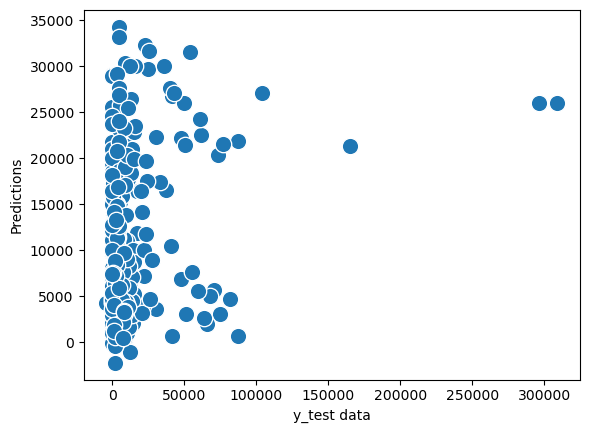

In [23]:
sns.scatterplot(x=y_test, y = y_pred, s=140)
plt.xlabel('y_test data')
plt.ylabel('Predictions')

In [24]:
from sklearn.metrics import mean_absolute_error
print('MAE:', mean_absolute_error(y_test,y_pred))

from sklearn.metrics import mean_squared_error
print("MSE",mean_squared_error(y_test,y_pred))

import numpy as np
print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))

from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_pred)
print("R2 Score:", r2)      # We use this as our main metric

MAE: 13593.369012532703
MSE 897389904.3976878
RMSE 29956.46682100023
R2 Score: 0.06251460515674723


In [25]:
data = data.reset_index()
NewData = data
NewData

,Date,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),Sum New Cases
0,2020-01-22,0.525000,24.782447,0.031561,0.0
1,2020-01-23,0.670690,26.067553,0.025876,0.0
2,2020-01-24,0.690351,25.952660,0.026554,0.0
3,2020-01-25,0.585965,21.463402,0.028829,0.0
4,2020-01-26,0.508772,17.300521,0.033949,0.0
...,...,...,...,...,...
996,2022-10-14,0.348958,16.988068,0.046513,7142.0
997,2022-10-15,0.320833,12.774719,0.043252,0.0
998,2022-10-16,0.321875,14.714773,0.039692,0.0
999,2022-10-17,0.442708,21.621023,0.043669,0.0


In [26]:
# For CO conc (ppm) & Sum New Cases
## Perform regression modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
import calendar

# Convert datetime to int
#x = data['Date'].values.astype(int) / 10**9  # Convert to seconds (UNIX epoch start)
#x = x.reshape(-1, 1)


x = NewData['CO conc (ppm)']
y = NewData['Sum New Cases']

#--------------------------------------------------------------
# Linear regression model
#--------------------------------------------------------------
# Stastical approach
x_lms = sm.add_constant(x)
linear_model_stat = sm.OLS(y, x_lms)
lms_results = linear_model_stat.fit()
p_values = lms_results.pvalues[1:]

# Machine learning approach (no p-values)
linear_model = LinearRegression()
linear_model.fit(x_lms, y)
y_linear_pred = linear_model.predict(x_lms)

# Calculate R2 and RMSE for linear regression model
linear_r2 = r2_score(y, y_linear_pred)
linear_rmse = np.sqrt(mean_squared_error(y, y_linear_pred))

print("Model Evaluation")
print("\nLinear Regression: RMSE=%.2f, R2=%.2f" % (linear_rmse, linear_r2))
for i, p_value in enumerate(p_values.index):
  print(f'P({p_value}): {p_values[i]}')

if any(p_values <= 0.05):
  print("There is a significant relationship between the predictor and the response\n")
else:
  print("There is no significant relationship between the predictor and the response\n")


# Plot the model
import plotly.graph_objects as go

xtt = NewData['CO conc (ppm)']#.dt.strftime('%Y-%m-%d')
scatter_actual = go.Scatter(x=xtt, y=y, mode='markers', name='Actual', marker=dict(color='blue', opacity=0.3))

line_regression = go.Scatter(x=xtt, y=y_linear_pred, mode='lines', name='LR', line=dict(color='red', dash='dash'))

data = [scatter_actual, line_regression]

layout = go.Layout(xaxis=dict(title='CO conc (ppm)'),
                   yaxis=dict(title='Sum New Cases'),
                   title='Linear Regression Model for COVID-19 New Cases & CO conc (ppm)',
                   showlegend=True,
                   height=600)

fig = go.Figure(data=data, layout=layout)
fig.show()

LinearRegression()

Model Evaluation

Linear Regression: RMSE=26992.09, R2=0.05
P(CO conc (ppm)): 7.097920677671734e-14
There is a significant relationship between the predictor and the response



In [27]:
# For NO2 conc (ppb) & Sum New Cases
## Perform regression modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
import calendar

# Convert datetime to int
#x = data['Date'].values.astype(int) / 10**9  # Convert to seconds (UNIX epoch start)
#x = x.reshape(-1, 1)


x = NewData['NO2 conc (ppb)']
y = NewData['Sum New Cases']

#--------------------------------------------------------------
# Linear regression model
#--------------------------------------------------------------
# Stastical approach
x_lms = sm.add_constant(x)
linear_model_stat = sm.OLS(y, x_lms)
lms_results = linear_model_stat.fit()
p_values = lms_results.pvalues[1:]

# Machine learning approach (no p-values)
linear_model = LinearRegression()
linear_model.fit(x_lms, y)
y_linear_pred = linear_model.predict(x_lms)

# Calculate R2 and RMSE for linear regression model
linear_r2 = r2_score(y, y_linear_pred)
linear_rmse = np.sqrt(mean_squared_error(y, y_linear_pred))

print("Model Evaluation")
print("\nLinear Regression: RMSE=%.2f, R2=%.2f" % (linear_rmse, linear_r2))
for i, p_value in enumerate(p_values.index):
  print(f'P({p_value}): {p_values[i]}')

if any(p_values <= 0.05):
  print("There is a significant relationship between the predictor and the response\n")
else:
  print("There is no significant relationship between the predictor and the response\n")


# Plot the model
import plotly.graph_objects as go

xtt = NewData['NO2 conc (ppb)']#.dt.strftime('%Y-%m-%d')
scatter_actual = go.Scatter(x=xtt, y=y, mode='markers', name='Actual', marker=dict(color='blue', opacity=0.3))

line_regression = go.Scatter(x=xtt, y=y_linear_pred, mode='lines', name='LR', line=dict(color='red', dash='dash'))

data = [scatter_actual, line_regression]

layout = go.Layout(xaxis=dict(title='NO2 conc (ppb)'),
                   yaxis=dict(title='Sum New Cases'),
                   title='Linear Regression Model for COVID-19 New Cases & NO2 conc (ppb)',
                   showlegend=True,
                   height=600)

fig = go.Figure(data=data, layout=layout)
fig.show()

LinearRegression()

Model Evaluation

Linear Regression: RMSE=27054.11, R2=0.05
P(NO2 conc (ppb)): 7.315812279458106e-13
There is a significant relationship between the predictor and the response



In [28]:
# For O3 conc (ppm) & Sum New Cases
## Perform regression modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
import calendar

# Convert datetime to int
#x = data['Date'].values.astype(int) / 10**9  # Convert to seconds (UNIX epoch start)
#x = x.reshape(-1, 1)


x = NewData['O3 conc (ppm)']
y = NewData['Sum New Cases']

#--------------------------------------------------------------
# Linear regression model
#--------------------------------------------------------------
# Stastical approach
x_lms = sm.add_constant(x)
linear_model_stat = sm.OLS(y, x_lms)
lms_results = linear_model_stat.fit()
p_values = lms_results.pvalues[1:]

# Machine learning approach (no p-values)
linear_model = LinearRegression()
linear_model.fit(x_lms, y)
y_linear_pred = linear_model.predict(x_lms)

# Calculate R2 and RMSE for linear regression model
linear_r2 = r2_score(y, y_linear_pred)
linear_rmse = np.sqrt(mean_squared_error(y, y_linear_pred))

print("Model Evaluation")
print("\nLinear Regression: RMSE=%.2f, R2=%.2f" % (linear_rmse, linear_r2))
for i, p_value in enumerate(p_values.index):
  print(f'P({p_value}): {p_values[i]}')

if any(p_values <= 0.05):
  print("There is a significant relationship between the predictor and the response\n")
else:
  print("There is no significant relationship between the predictor and the response\n")


# Plot the model
import plotly.graph_objects as go

xtt = NewData['O3 conc (ppm)']#.dt.strftime('%Y-%m-%d')
scatter_actual = go.Scatter(x=xtt, y=y, mode='markers', name='Actual', marker=dict(color='blue', opacity=0.3))

line_regression = go.Scatter(x=xtt, y=y_linear_pred, mode='lines', name='LR', line=dict(color='red', dash='dash'))

data = [scatter_actual, line_regression]

layout = go.Layout(xaxis=dict(title='O3 conc (ppm)'),
                   yaxis=dict(title='Sum New Cases'),
                   title='Linear Regression Model for COVID-19 New Cases & O3 conc (ppm)',
                   showlegend=True,
                   height=600)

fig = go.Figure(data=data, layout=layout)
fig.show()

LinearRegression()

Model Evaluation

Linear Regression: RMSE=26866.04, R2=0.06
P(O3 conc (ppm)): 6.150791032421476e-16
There is a significant relationship between the predictor and the response

